<a href="https://colab.research.google.com/github/ashfarhangi/Massive_Storage_and_Big_Data/blob/master/code/11_pyTorch_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we take a look at the facebooks pytorch library for developing neural networks

In [1]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101


In [2]:
import torch
from datetime import datetime
now = datetime.now().date() 
print('torch version: ',torch.__version__)
print('Current Date:',now)

torch version:  1.7.0+cu101
Current Date: 2020-12-06


In [3]:
a = torch.tensor([1,2])
a.size()

torch.Size([2])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
x = torch.tensor([[2, 3], [1, 2]])
x.to(device)


tensor([[2, 3],
        [1, 2]])

Doing operations between GPU and CPU Tensors is not allowed


## Simple NN


## Import Libraries

In [6]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [7]:
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from torch import nn,optim
import torch.nn.functional as F
rcParams['figure.figsize'] = (12,8)

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
RANDOM_SEED =47
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data

In [9]:
#upload ur data to google drive and turn this link 
!gdown --id 1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7

Downloading...
From: https://drive.google.com/uc?id=1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7
To: /content/weatherAUS.csv
14.2MB [00:00, 65.9MB/s]


In [10]:
df = pd.read_csv('/content/weatherAUS.csv',parse_dates=['Date'])
# Before runnig the line below, take a slice of columns that are important and try to drop their values instead
df.dropna()
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
# todo one hot encode the location


In [11]:
df=df.dropna(how='any')
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0
...,...,...,...,...,...
142188,0.0,27.0,1024.7,0.0,0
142189,0.0,24.0,1024.6,0.0,0
142190,0.0,21.0,1023.5,0.0,0
142191,0.0,24.0,1021.0,0.0,0


## Preprocessing

Text(0.5, 1.0, 'Chance of rain: 0    0.778762\n1    0.221238\nName: RainTomorrow, dtype: float64')

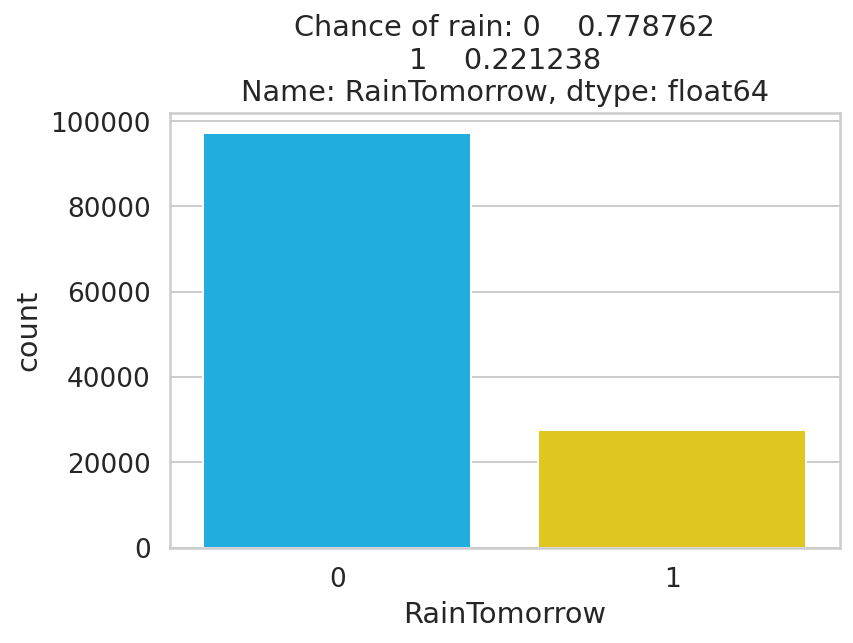

In [12]:
sns.countplot(df.RainTomorrow)
p = df.RainTomorrow.value_counts()/ df.shape[0]
plt.title('Chance of rain: '+str(p))


In [13]:
df[df.RainTomorrow == 1]

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
8,0.0,9.0,1008.9,0.0,1
10,0.0,22.0,1011.8,0.0,1
11,2.2,91.0,1010.5,1.0,1
12,15.6,93.0,994.3,1.0,1
15,0.0,82.0,1012.2,0.0,1
...,...,...,...,...,...
142059,0.4,24.0,1007.0,0.0,1
142124,0.0,91.0,1015.9,0.0,1
142125,6.8,65.0,1016.9,1.0,1
142126,12.6,59.0,1018.1,1.0,1


Possible ways to mitigate the data imbalance:

1.  oversampling - replicate examples from the under-represented class (claims)
2. undersampling - sample from the most represented class (no claims) to keep only a few examples
3. generate synthetic data - create new synthetic examples from the under-represented class



In [14]:
from sklearn.utils import resample

rain= df[df.RainTomorrow == 1]
norain = df[df.RainTomorrow == 0]

rain = resample(rain,
                          replace=True,
                          n_samples=len(norain),
                          random_state=RANDOM_SEED)
df1 = pd.merge(rain,norain,how='outer')
df1

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,7.6,89.0,1021.8,1.0,1
1,7.6,89.0,1021.8,1.0,1
2,7.6,89.0,1021.8,1.0,1
3,7.6,89.0,1021.8,1.0,1
4,7.6,89.0,1021.8,1.0,1
...,...,...,...,...,...
194201,0.0,26.0,1030.2,0.0,0
194202,0.0,23.0,1031.8,0.0,0
194203,0.0,29.0,1031.0,0.0,0
194204,0.0,32.0,1027.2,0.0,0


Text(0.5, 1.0, 'Resampled Chance of rain: 1    0.5\n0    0.5\nName: RainTomorrow, dtype: float64')

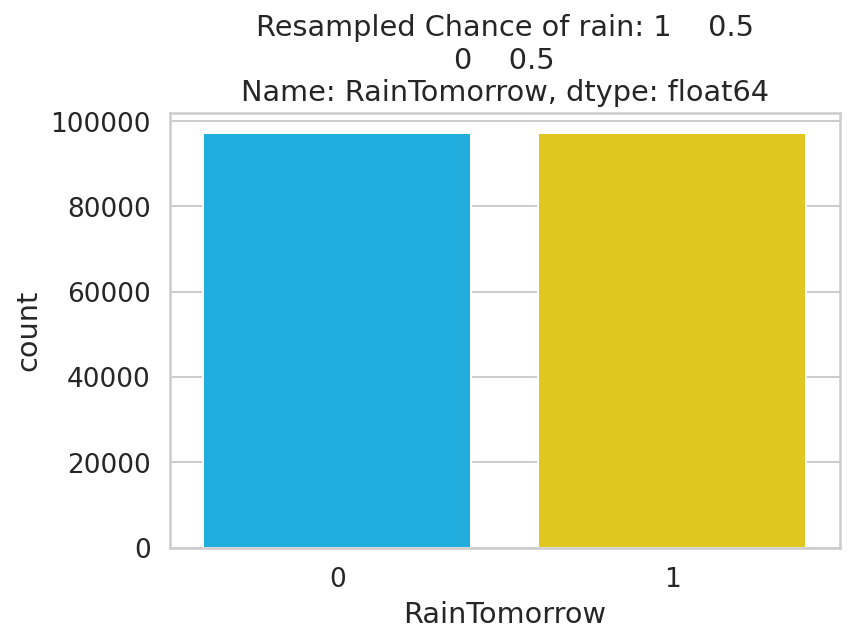

In [15]:
sns.countplot(df1.RainTomorrow)
p = df1.RainTomorrow.value_counts()/ df1.shape[0]
plt.title('Resampled Chance of rain: '+str(p))


In [16]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## Neural Network

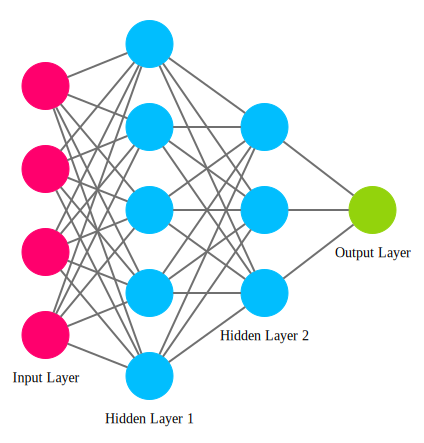

In [18]:
# pytorch likes functional model rather than the sequential model of tensorflow library
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
    
# F as functional 
# One of the cool features of Neural Networks is that they can approximate non-linear functions. In
# fact, it is proven that they can approximate any function⁶.
# Good luck approximating non-linear functions by stacking linear layers. Activation functions allow
# you to break from the linear world and learn (hopefully) more

net = Net(X_train.shape[1])  
ann_viz(net,view=True,filename="myNetwork.png")


In [19]:
criterion = nn.BCELoss()
#binary cross entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

net = net.to(device)

criterion = criterion.to(device)

In [21]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [22]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 0.597, accuracy: 0.779
Test  set - loss: 0.602, accuracy: 0.777

epoch 100
Train set - loss: 0.505, accuracy: 0.779
Test  set - loss: 0.508, accuracy: 0.777

epoch 200
Train set - loss: 0.475, accuracy: 0.779
Test  set - loss: 0.478, accuracy: 0.777

epoch 300
Train set - loss: 0.433, accuracy: 0.779
Test  set - loss: 0.436, accuracy: 0.777

epoch 400
Train set - loss: 0.42, accuracy: 0.779
Test  set - loss: 0.423, accuracy: 0.777

epoch 500
Train set - loss: 0.416, accuracy: 0.83
Test  set - loss: 0.419, accuracy: 0.831

epoch 600
Train set - loss: 0.414, accuracy: 0.832
Test  set - loss: 0.417, accuracy: 0.832

epoch 700
Train set - loss: 0.412, accuracy: 0.833
Test  set - loss: 0.415, accuracy: 0.832

epoch 800
Train set - loss: 0.41, accuracy: 0.833
Test  set - loss: 0.413, accuracy: 0.832

epoch 900
Train set - loss: 0.409, accuracy: 0.834
Test  set - loss: 0.412, accuracy: 0.832



In [23]:
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

In [24]:
net = torch.load(MODEL_PATH)

In [25]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.84      0.96      0.90     19373
     Raining       0.74      0.38      0.50      5565

    accuracy                           0.83     24938
   macro avg       0.79      0.67      0.70     24938
weighted avg       0.82      0.83      0.81     24938



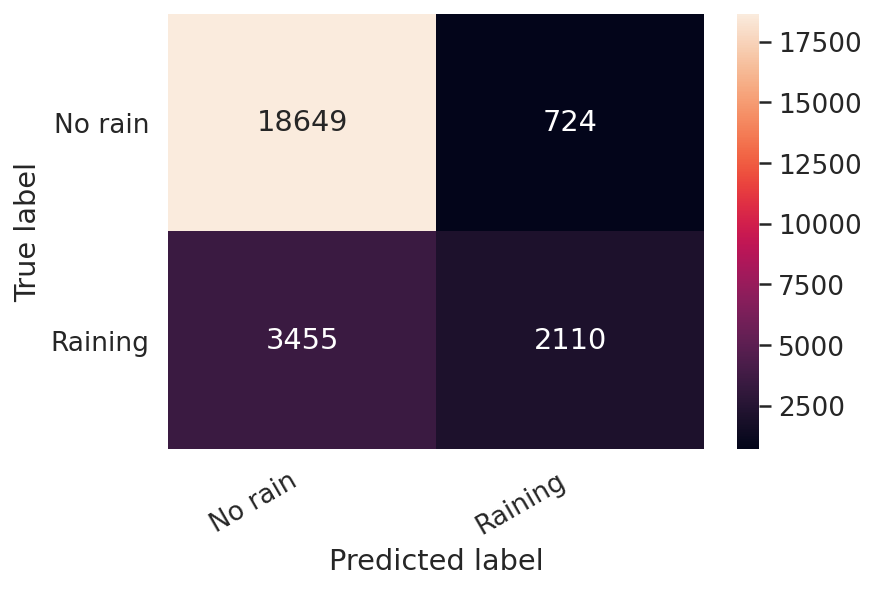

In [26]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [27]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

In [28]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True

In [41]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

True

# Keras (TensorFlow) High level for simple tasks[link text](https://)

Same accuracy with how many lines of code?

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test

(        Rainfall  Humidity3pm  RainToday  Pressure9am
 95003        0.0         25.0        0.0       1017.2
 76112        0.0         58.0        0.0       1018.6
 126436       1.2         55.0        1.0       1013.6
 109209       3.0         56.0        1.0       1012.9
 13876        0.0          8.0        0.0       1010.2
 ...          ...          ...        ...          ...
 29922       46.0         73.0        1.0       1021.1
 12184        0.0         21.0        0.0       1023.8
 128441       0.0         49.0        0.0       1020.2
 61532        0.0         53.0        0.0       1022.5
 115977       9.2         54.0        1.0       1021.3
 
 [99751 rows x 4 columns],
         Rainfall  Humidity3pm  RainToday  Pressure9am
 44245       49.0         92.0        1.0       1017.7
 84629        0.0         55.0        0.0       1015.7
 120185       0.0         46.0        0.0       1033.1
 116314       0.0         61.0        0.0       1019.9
 69177       13.4         32.0      

In [43]:
import keras
from keras import layers,models,metrics,optimizers,utils

In [44]:
X_train.shape


(99751, 4)

In [48]:
model = models.Sequential()
model.add(layers.Dense(5,input_shape=X_train.shape,activation='relu',name='Layer_1'))
model.add(layers.Dense(3,activation='relu',name='Layer_2'))
model.add(layers.Dense(1,activation='sigmoid',name='Layer_3'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=16,epochs=10)
model.summary()

Epoch 1/10
6235/6235 [==============================] - 6s 996us/step - loss: 0.5018 - accuracy: 0.8245
Epoch 2/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4102 - accuracy: 0.8288
Epoch 3/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4073 - accuracy: 0.8307
Epoch 4/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4055 - accuracy: 0.8306
Epoch 5/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4042 - accuracy: 0.8316
Epoch 6/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4038 - accuracy: 0.8327
Epoch 7/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4026 - accuracy: 0.8323
Epoch 8/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4023 - accuracy: 0.8329
Epoch 9/10
6235/6235 [==============================] - 6s 1ms/step - loss: 0.4011 - accuracy: 0.8331
Epoch 10/10
6235/6235 [==============================] - 6s 995us/step - loss: 0

In [49]:
model.evaluate(X_test,y_test)

780/780 [==============================] - 1s 882us/step - loss: 0.4044 - accuracy: 0.8325


[0.4043850302696228, 0.8324645161628723]

In [50]:
X_test[0:1]

,Rainfall,Humidity3pm,RainToday,Pressure9am
44245,49.0,92.0,1.0,1017.7


In [51]:
# hmap = sns.heatmap(df_cm, annot=True, fmt="d")
# hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
# hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
# plt.ylabel('True label')
# plt.xlabel('Predicted label');

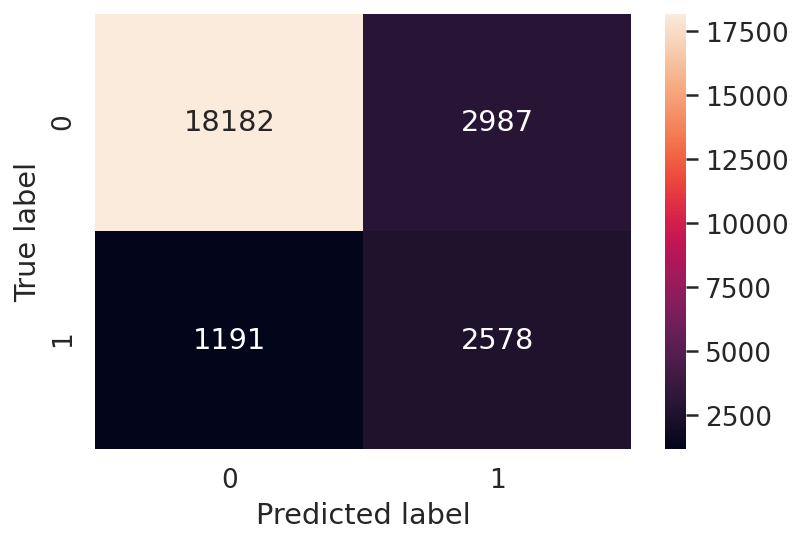

In [52]:
predicted = np.round(model.predict(X_test))
matrix = confusion_matrix(predicted,y_test)
sns.heatmap(matrix,annot=True,fmt='d')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [53]:
model.predict(X_test)

array([[0.8954895 ],
       [0.19386223],
       [0.13721517],
       ...,
       [0.7130633 ],
       [0.09112731],
       [0.07426062]], dtype=float32)

In [54]:
y_test

,RainTomorrow
44245,1
84629,0
120185,0
116314,0
69177,0
...,...
11824,0
31826,0
17837,1
49915,0


# Conclusion:

If you have a simple task at hand, you can just use the Keras high level API. But if you are researching and want to have better efficiency, accuracy, and more control over every part of the code try PyTorch.
Requires great amount to coding and debuging and writing as tensorflow and Keras has better documentation, better usabilty and more ready to be used frameworks.


1.   No need to transform into torch tensors (automatic)
2.   No need to call class, and do extra, such process can be done by tensorflow function rather than the sequential model.
3. Its good for begineers 



## Reference


1.   https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
2.   Get S done by pytorch
3. [Data imbalace](https://curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/)
